# GBM (Gradient Boosting Machine)
---

부스팅 알고리즘은 여러 개의 week learner를 순차적으로 학습하면서 각 step에서 잘못 예측된 데이터에 대해 가중치를 부여해 오류를 개선해 나가는 학습 방식입니다.

부스팅 알고리즘은 대표적으로 AdaBoost(Adaptive boosting)와 Gradient boost가 있습니다. 

`다음은 AdaBoost가 학습하는 방법을 도식화 한 것입니다.`

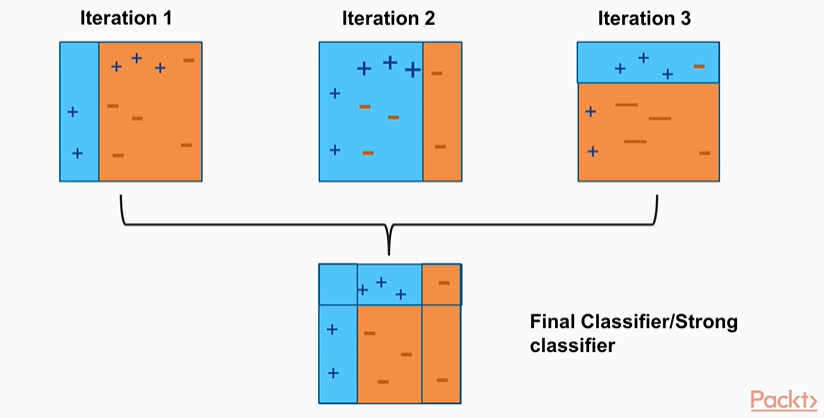

각 Iteration(step)에서 잘못 예측된 데이터에 대하여 가중치를 부여한 예측 결정 기준을 결합해 최종 예측 결정 기준을 만들게 됩니다.

GBM(Gradient Boost Machine)도 AdaBoost와 유사하게 동작하지만 가중치 업데이트의 방식이 경사 하강법(Gradient descent)을 사용하는 것이 차이점입니다.

(경사 하강법에 대해선 회귀를 다룰 때 자세히 다루도록 하겠습니다.)

`GBM은 CART 기반의 다른 알고리즘과 마찬가지로 분류 뿐만 아니라 회귀 문제에도 사용 될 수 있습니다.`

sklearn의 GradientBoostingClassifier 클래스를 이용해 행동예측 데이터를 분류하는 모델을 생성합니다.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

In [16]:
# feature.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리
feature_name_df = pd.read_csv('../data/HumanActivity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
feature_name_df.head()

# 피처명 index를 제거하고 피처명만 리스트 객체로 생성한 귀 샘플로 10개만 추출

feature_name = feature_name_df.iloc[:, 1].values.tolist()

# 중복된 피처명

feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('../data/HumanActivity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처, 데스트 피처를 DataFrame으로 로딩하고, 칼럼명은 feature_name 으로 적용헤 준다.
    X_train= pd.read_csv('../data/HumanActivity/train/X_train.txt',sep='\s+',names=feature_name)
    X_test= pd.read_csv('../data/HumanActivity/test/X_test.txt',sep='\s+',names=feature_name)
                        
    # 학습 레이블과 테스트 레이블을 DataFrame으로 로딩하고, 칼럼명은 action으로 적용해 준다.
    y_train= pd.read_csv('../data/HumanActivity/train/y_train.txt',sep='\s+',names=['action'])
    y_test= pd.read_csv('../data/HumanActivity/test/y_test.txt',sep='\s+',names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

print('## 학습 피처 데이터셋 info()')
print(X_train.info())

column_index    42
dtype: int64
## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [17]:
# GBM 수행 시간 측정 위한 시작 시간 성정
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
pred = gb_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print('GBM 정확도 :',accuracy)
print('GBM 수행 시간 :{:.1f}초'.format(time.time() - start_time))

GBM 정확도 : 0.9389209365456397
GBM 수행 시간 :650.9초


GBM은 RandomForest보다 나은 예측 성능을 보이는 경우가 많습니다.

하지만 수행 시간이 오래 걸리리는 것이 GBM의 주요 과제이므로(위스콘신 데이터는 총 569개이기 때문에 속도가 빠름) 빠른 수행 시간을 요구하는 경우에는 RandomForest가 더 적합하다고 할 수 있습니다.

# GBM 하이퍼 파라미터 튜닝
---

- loss : 경사 하강법에서 사용할 비용 함수를 지정. 기본값 'devidence'


- learning_rate : GBM이 학습을 진행할 때마다 적용하는 학습률 기본값(0.1). weak learner가 순차적으로 오류 값을 보정해 나가는 데 적용하는 계수로 0 ~ 1 사이의 값을 가집니다. 경사하강법에서 오류가 낮아지는 지점을 찾아가기 위한 계수라고 생각할 수 있습니다. 너무 작게 설정하는 경우 업데이트 되는 값이 작아져서 예측 성능이 높아질 가능성이 높지만 많은 week learner는 순차적인 반복이 필요해 수행시간이 길어지고 모든 weak learner의 반복이 완료돼도 최소 오류값을 찾지 못할 수 있습니다. 반대로 너무 큰 값을 설정하면 최소 오류 값을 찾지 못하고 그냥 지나쳐 버려 예측 성능이 떨어질 가능성이 높아지지만 수행 시간이 단축됩니다. 이러한 특성으로 learning_rate은 n_estimator와 상호 보완적으로 조합해 사용합니다.


- n_estimators: weak learner의 개수입니다. 기본값은 100으로 weak learner가 많을수록 예측 성능이 일정 수준까지 좋아질 수 있지만 수행 시간이 길어집니다.


- subsample: weak learner가 학습에 사용하는 데이터 샘플링의 비율입니다. 기본값은 1이며, 이는 전체 데이터를 기반으로 학습한다는 의미입니다. 과적합이 염려되는 경우 1보다 작은 값을 설정합니다.

이제  앞서 생성한 GBM 분류기를 GridSearchCV를 통해 하이퍼 파라미터를 최적화 하겠습니다.

기본적으로 GBM은 시간이 오래 걸려 GridSearchCV를 진행하면 시간이 오래 걸릴 수 있습니다.

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate':[0.05, 0.1]
}
# verbose  0:silent, 1:progressb bar, 2:one line per epoch.
grid_cv = GridSearchCV(gb_clf, param_grid = params, cv = 2, verbose = 1)
grid_cv.fit(X_train, y_train)
print('최적의 파라미터 :',grid_cv.best_params_)
print('최고의 예측 정확도 :',grid_cv.best_score_)

수행시간이 너무 길어지는 관계로 실행은 생략하겠습니다.